In [1]:
# YOLOE-11L (seg checkpoint) - can you save this
!wget https://github.com/ultralytics/assets/releases/download/v8.3.0/yoloe-11l-seg.pt

--2026-01-12 20:28:09--  https://github.com/ultralytics/assets/releases/download/v8.3.0/yoloe-11l-seg.pt
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/521807533/f1fb9408-4027-4011-88c7-aa6b0d77f44e?sp=r&sv=2018-11-09&sr=b&spr=https&se=2026-01-12T13%3A18%3A19Z&rscd=attachment%3B+filename%3Dyoloe-11l-seg.pt&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2026-01-12T12%3A18%3A12Z&ske=2026-01-12T13%3A18%3A19Z&sks=b&skv=2018-11-09&sig=UnzQceaArGONwtgmHzDtk4iGY9VbBHBOPj4ggS4%2Fq%2Bo%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2ODIyMjY5MiwibmJmIjoxNzY4MjIwODkyLCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjd

In [2]:
!pip install -U ultralytics onnx onnxruntime onnxslim

  Using cached onnxruntime-1.23.2-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.1 kB)
  Using cached onnxslim-0.1.82-py3-none-any.whl.metadata (10 kB)
  Using cached matplotlib-3.10.8-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (52 kB)
  Using cached opencv_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
  Using cached pillow-12.1.0-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (8.8 kB)
  Using cached pyyaml-6.0.3-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (2.4 kB)
  Using cached torch-2.9.1-cp313-cp313-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached torchvision-0.24.1-cp313-cp313-manylinux_2_28_x86_64.whl.metadata (5.9 kB)
  Using cached ultralytics_thop-2.0.18-py3-none-any.whl.metadata (14 kB)
  Using cached ml_dtypes-0.5.4-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (8.9 kB)
  Using cache

Ultralytics points to the RAM++ predefined list

In [3]:
!curl -L -o labels_yoloe_pf_4585.txt \
  https://github.com/xinyu1205/recognize-anything/raw/main/ram/data/ram_tag_list.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 41904  100 41904    0     0  39763      0  0:00:01  0:00:01 --:--:-- 69262


#### Convert the segmentation checkpoint to a detection checkpoint (optional but cleaner)

In [4]:
from ultralytics import YOLOE
from ultralytics.utils.patches import torch_load

# Build a detection model skeleton, then load seg weights into it
det_model = YOLOE("yoloe-11l.yaml")
state = torch_load("yoloe-11l-seg.pt")
det_model.load(state["model"])
det_model.save("yoloe-11l-det.pt")

print("Saved: yoloe-11l-det.pt")


Transferred 1108/1108 items from pretrained weights
Saved: yoloe-11l-det.pt


Freeze your “open vocab” class list + export ONNX

In [5]:
from ultralytics import YOLOE

# Load your detection checkpoint (or use yoloe-11l-seg.pt directly if you skip conversion)
model = YOLOE("yoloe-11l-det.pt")

# Choose the classes from YOLOE to detect in DeepStream
# names = ["person", "car", "bus", "truck", "motorcycle", "bicycle"]
# COCO80 = [
#   "person","bicycle","car","motorcycle","airplane","bus","train","truck","boat",
#   "traffic light","fire hydrant","stop sign","parking meter","bench","bird","cat","dog","horse","sheep","cow",
#   "elephant","bear","zebra","giraffe","backpack","umbrella","handbag","tie","suitcase",
#   "frisbee","skis","snowboard","sports ball","kite","baseball bat","baseball glove","skateboard","surfboard","tennis racket",
#   "bottle","wine glass","cup","fork","knife","spoon","bowl",
#   "banana","apple","sandwich","orange","broccoli","carrot","hot dog","pizza","donut","cake",
#   "chair","couch","potted plant","bed","dining table","toilet","tv","laptop","mouse","remote","keyboard","cell phone",
#   "microwave","oven","toaster","sink","refrigerator","book","clock","vase","scissors","teddy bear","hair drier","toothbrush"
# ]

TRAFFIC_LABELS = [
  # People & PPE
  "person","worker","pedestrian","cyclist","motorcyclist",
  "helmet","hard hat","reflective vest","face mask","backpack",

  # Core vehicles
  "bicycle","motorcycle","scooter","pmv","pmd",
  "car","taxi","van","pickup truck","minibus","bus",
  "truck","box truck","flatbed truck","tanker truck","container truck","trailer",
  "tow truck","ambulance","fire truck","police car","maintenance vehicle",

  # Roadway furniture / signs / signals
  "traffic light","pedestrian signal","traffic sign","speed limit sign","no entry sign",
  "stop sign","yield sign","direction sign","gantry sign","variable message sign",
  "road cone","bollard","barrier","jersey barrier","guardrail","fence",
  "lane marking","zebra crossing","road shoulder","kerb",

  # Common carried / dropped objects
  "umbrella","luggage","suitcase","box","cart","stroller",

  # Hazards / events (as “objects” you may want to detect)
  "smoke","fire","debris","fallen tree","spill","puddle","flooding",
  "accident","crashed vehicle","stopped vehicle",

  # Animals (useful for expressways)
  "dog","cat","bird"
]



# Freeze the text prompts into the model before export (key for DeepStream)
model.set_classes(TRAFFIC_LABELS, model.get_text_pe(TRAFFIC_LABELS))

# Export ONNX (static batch is simplest for DeepStream)
export_path = model.export(
    format="onnx",
    imgsz=640,        # set to your inference size
    opset=12,         # safe default for compatibility
    simplify=True,
    dynamic=False
)

# Write DeepStream labels file (order must match the names (labels) you set above)
with open("labels_yoloe.txt", "w") as f:
    for n in TRAFFIC_LABELS:
        f.write(n + "\n")

print("Exported:", export_path)
print("Wrote: labels_yoloe.txt")


requirements: Ultralytics requirement ['git+https://github.com/ultralytics/CLIP.git'] not found, attempting AutoUpdate...
  Cloning https://github.com/ultralytics/CLIP.git to /tmp/pip-req-build-jyt5xd2p
  Running command git clone --filter=blob:none --quiet https://github.com/ultralytics/CLIP.git /tmp/pip-req-build-jyt5xd2p
  Resolved https://github.com/ultralytics/CLIP.git to commit 643beff3883b5720d94b6b9c9eca12fa9fb72fb1
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/803.5 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.5/803.5 kB 38.5 MB/s  0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1382999 sha256=32d655edfcda


image 1/1 /home/n03an/code/deepstream_custom_parser/playground/notebooks/crowd_2.webp: 384x640 113 persons, 6 backpacks, 2 traffic lights, 1 pedestrian signal, 3 traffic signs, 1 bollard, 1 luggage, 131.7ms
Speed: 1.2ms preprocess, 131.7ms inference, 13.1ms postprocess per image at shape (1, 3, 384, 640)


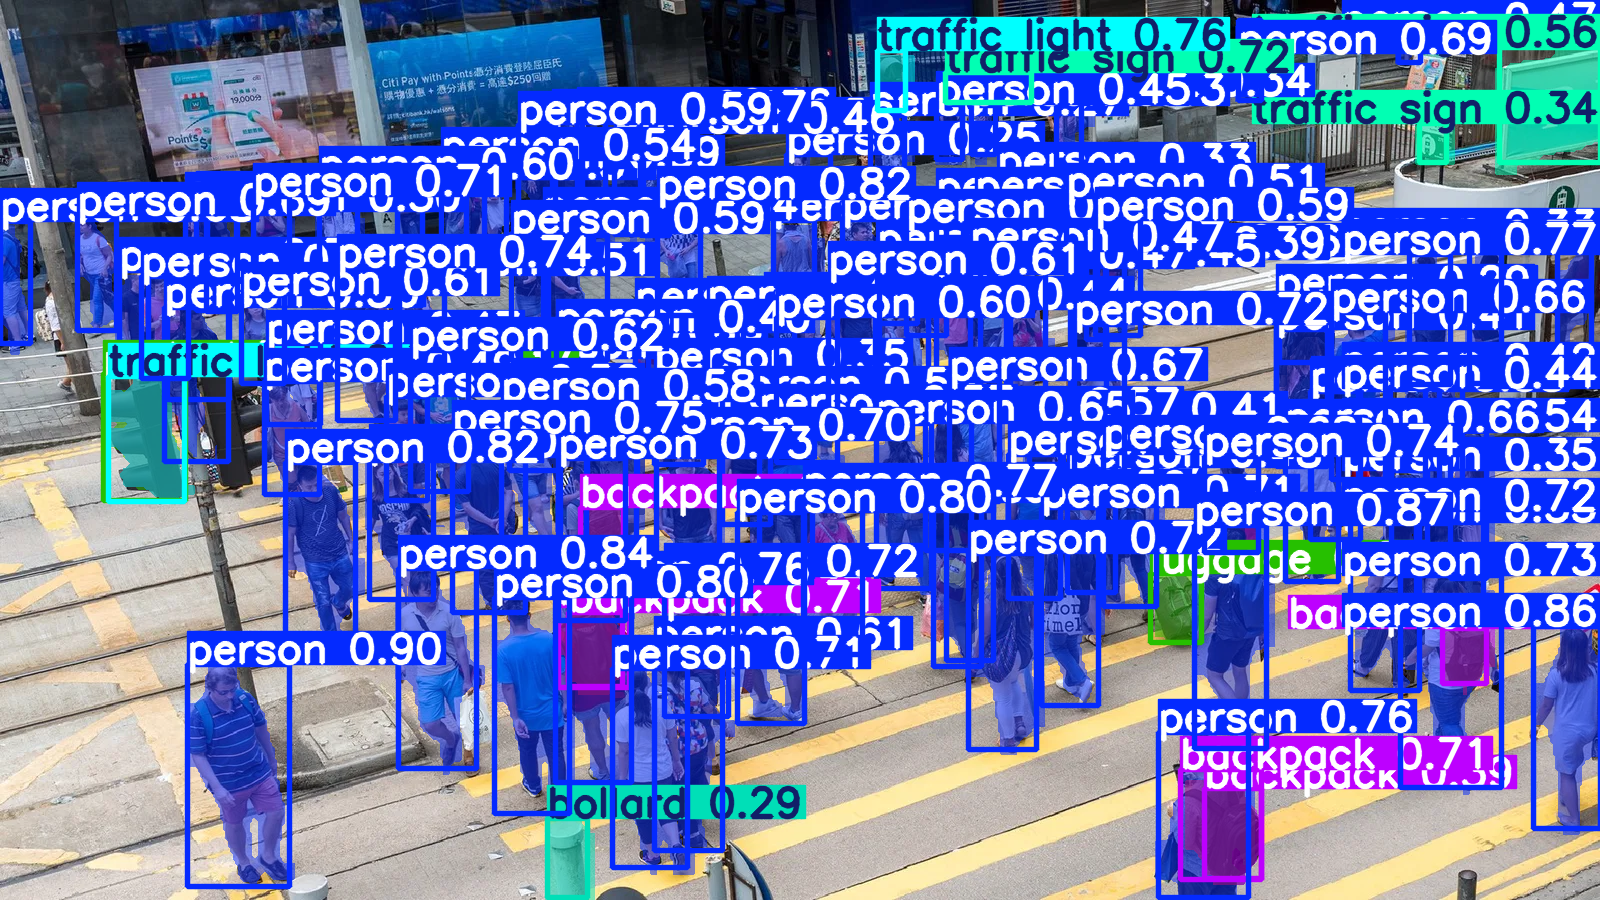

In [7]:
from ultralytics import YOLO

# Load pretrained YOLOE model and train on custom data
model = YOLO("yoloe-11l-seg.pt")

# Run inference using text prompts ("person", "bus")
model.set_classes(TRAFFIC_LABELS)
results = model.predict(source="crowd_2.webp")
results[0].show()  # display annotated output in notebook